In [1]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

In [2]:
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 789, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 789 (delta 19), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (789/789), 46.13 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (386/386), done.


In [3]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

In [4]:
!pip install segpy

import segpy
from segpy.reader import create_reader

     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 111 kB 49.3 MB/s 


In [5]:
filename = "Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

data = (data-np.min(data))/(np.max(data)-np.min(data))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

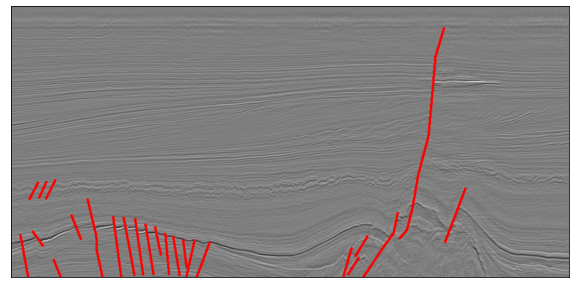

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

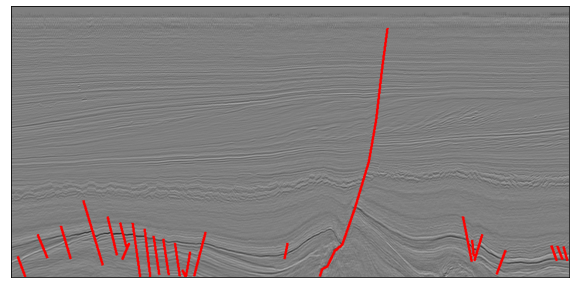

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

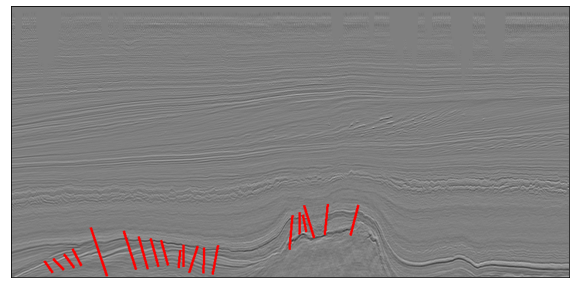

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

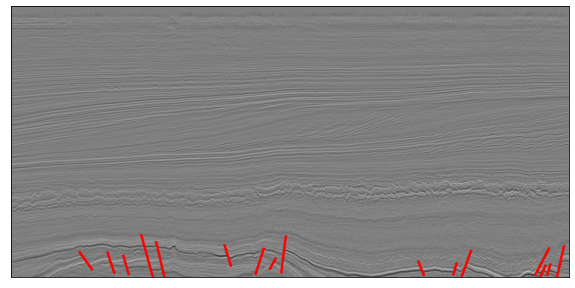

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

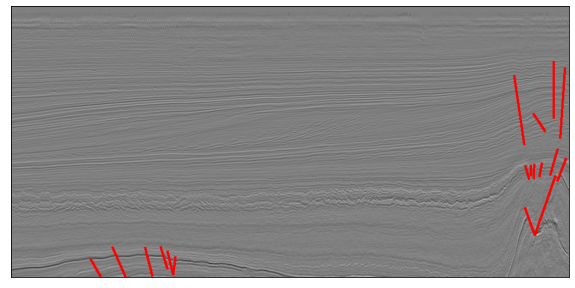

<IPython.core.display.Javascript object>

In [7]:
def load_label(inline):
    label = Image.open('./seismic_deep_learning/tutorial-3/mask_inline_' + str(inline) + '.png')
    label.load()
    label = np.asarray(label)[:,:,3]
    label = np.where(label > 0.5, 1, 0)
    return label


def plot_overlay(image, label):
    (tmax, xmax) = np.shape(image)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image
    image_rgb[:,:,1] = 255*image
    image_rgb[:,:,2] = 255*image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA')    
    background.paste(img, (0, 0), img)

    plt.imshow(background)
    plt.xticks([])
    plt.yticks([])



tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    label = load_label(100+100*i)
    plot_overlay(data[100+100*i,:,:], label)
    plt.xticks([])
    plt.yticks([])

In [8]:
def patchify(data, label, size, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size, size, 1))
    Y = np.zeros((number, size, size, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        t = random.randint(size//2, t_max-size//2)
        if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,0]  = data[t-size//2:t+size//2, x-size//2:x+size//2]
            Y[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y


# Parameters
size       = 64
threshold  = 0
num_train  = 8000
num_val    = 2000


# Validation data from inline 300
X_val = np.zeros((num_val,size,size,1))
Y_val = np.zeros((num_val,size,size,1))

label   = load_label(300)
seismic = data[300,...]
X_val,Y_val = patchify(seismic, label, size, num_val, threshold)


# Training data from inlines 100, 200, 400, 500
X_train = np.zeros((num_train,size,size,1))
Y_train = np.zeros((num_train,size,size,1))
n = 0
for inline in [100, 200, 400, 500]:
  label   = load_label(inline)
  seismic = data[inline,...]
  X_train[n:n+num_train//4,...],Y_train[n:n+num_train//4,...] = patchify(seismic, label, size, num_train//4, threshold) 
  n += num_train//4

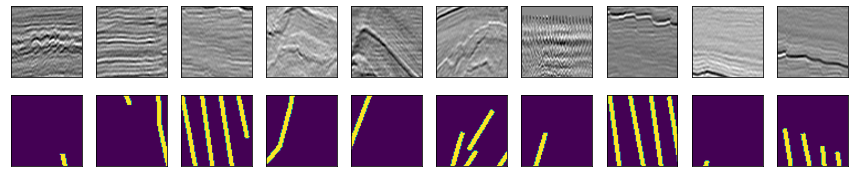

In [9]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


In [10]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model




model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [11]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=5)

Epoch 1/5
250/250 [==============================] - 50s 69ms/step - loss: 0.2221 - acc: 0.9425 - val_loss: 0.2187 - val_acc: 0.9406
Epoch 2/5
250/250 [==============================] - 17s 67ms/step - loss: 0.1921 - acc: 0.9449 - val_loss: 0.1939 - val_acc: 0.9411
Epoch 3/5
250/250 [==============================] - 17s 67ms/step - loss: 0.1271 - acc: 0.9544 - val_loss: 0.2177 - val_acc: 0.9366
Epoch 4/5
250/250 [==============================] - 17s 67ms/step - loss: 0.0772 - acc: 0.9699 - val_loss: 0.2733 - val_acc: 0.9426
Epoch 5/5
250/250 [==============================] - 17s 67ms/step - loss: 0.0508 - acc: 0.9795 - val_loss: 0.3671 - val_acc: 0.9387


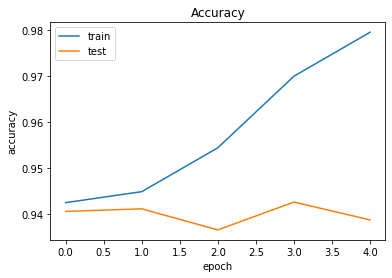

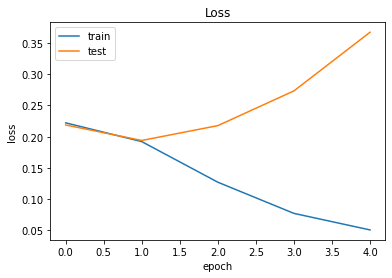

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_true = Y_val    

cm = np.zeros((2,2))

for n in range(Y_true.shape[0]):

  y_true = Y_true[n,:,:,0].round().flatten()
  y_pred = Y_pred[n,:,:,0].round().flatten()

  cm_batch = confusion_matrix(y_true, y_pred)
              

  cm = cm + cm_batch

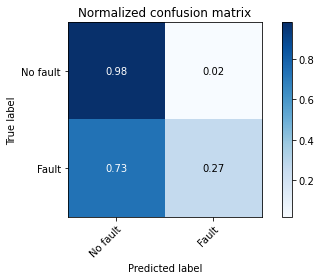

In [14]:
cmap=plt.cm.Blues
normalize = True

title = 'Normalized confusion matrix'


# Only use the labels that appear in the data
classes = ['No fault','Fault']

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

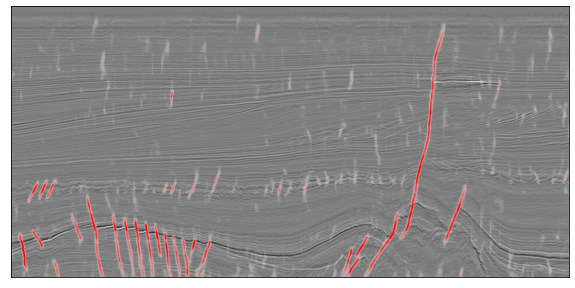

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

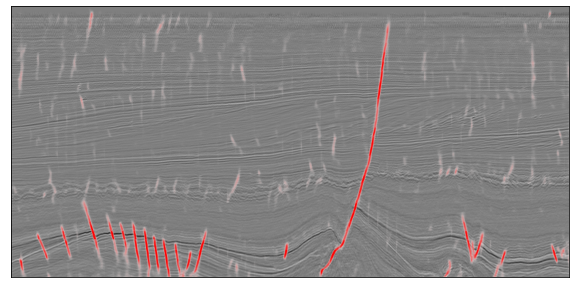

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

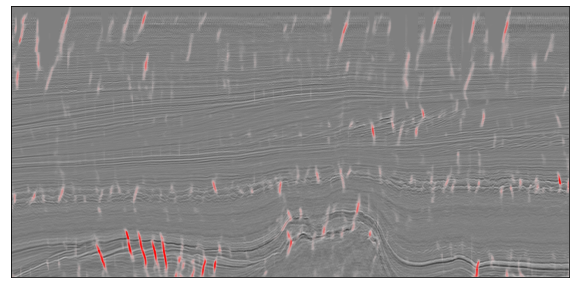

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

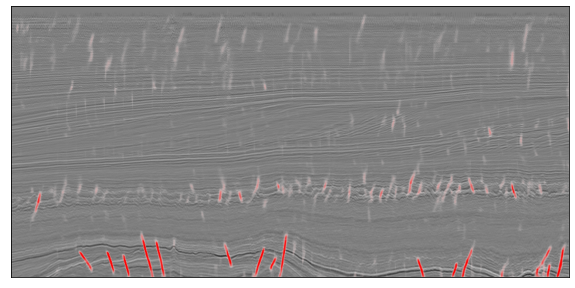

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

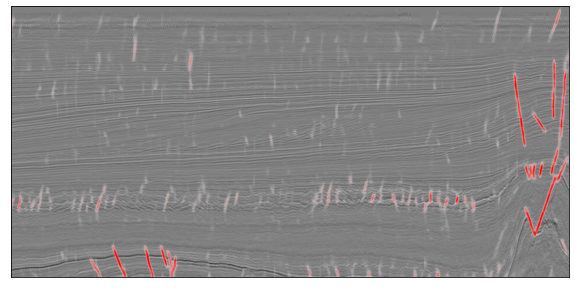

<IPython.core.display.Javascript object>

In [15]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 16
dx = 16

(_, t_max, x_max) = data.shape



tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    data_tiles   = tile(data[100+100*i,:,:], size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data[100+100*i,:,:], result[:,:,0])
    plt.xticks([])
    plt.yticks([])

In [23]:
label.shape

(462, 951)

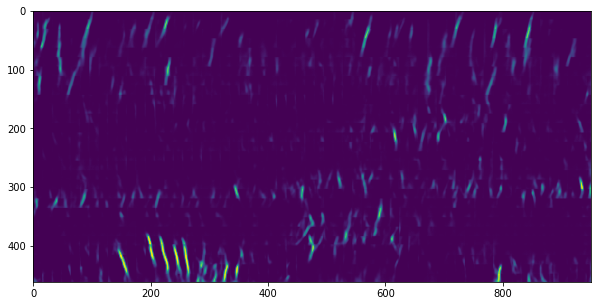

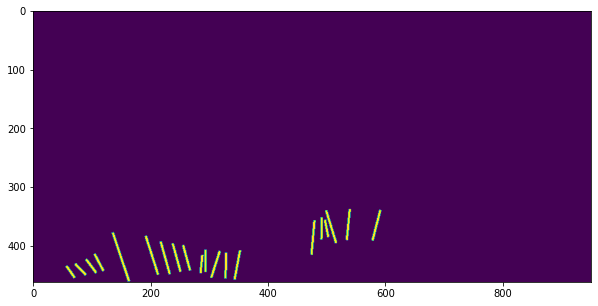

In [27]:
plt.figure(figsize=(10,10))
data_tiles   = tile(data[100+100*2,:,:], size, dt, dx)
result_tiles = model.predict_on_batch(data_tiles)
result       = merge(result_tiles, t_max, x_max, size, dt, dx)
label = load_label(100+100*2)
plt.imshow(result[:,:,0])
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(label)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

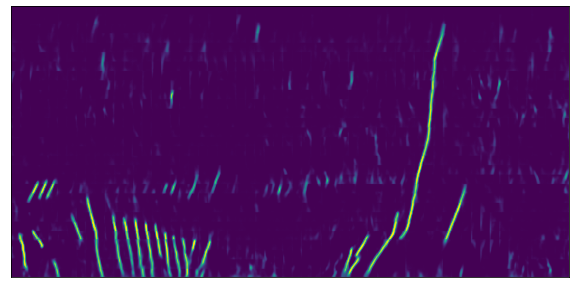

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

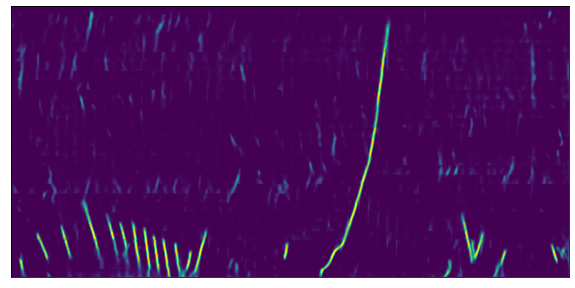

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

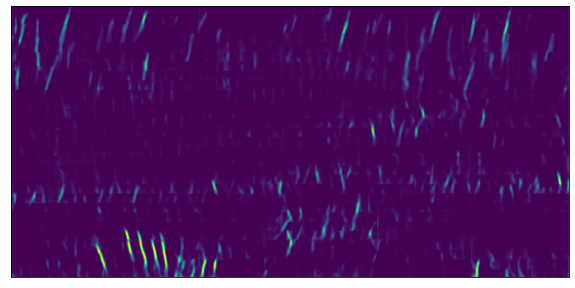

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

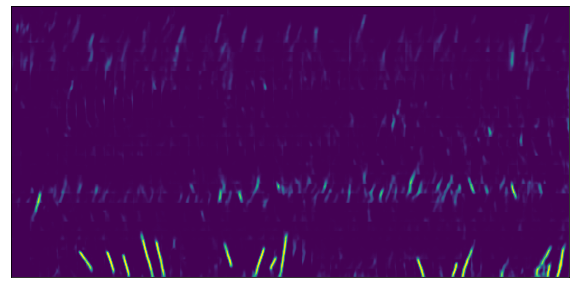

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

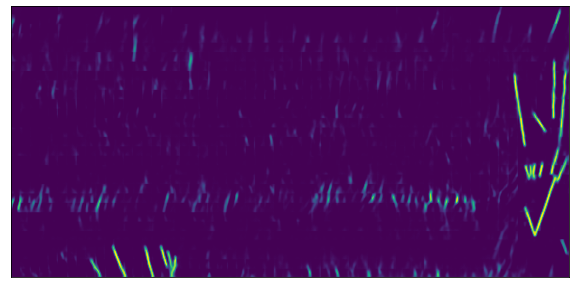

<IPython.core.display.Javascript object>

In [17]:
for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    data_tiles   = tile(data[100+100*i,:,:], size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plt.imshow(result[:,:,0])
    plt.xticks([])
    plt.yticks([])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

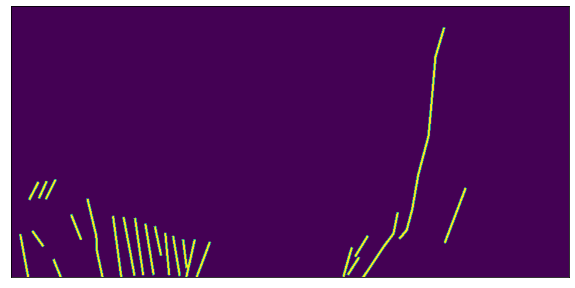

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

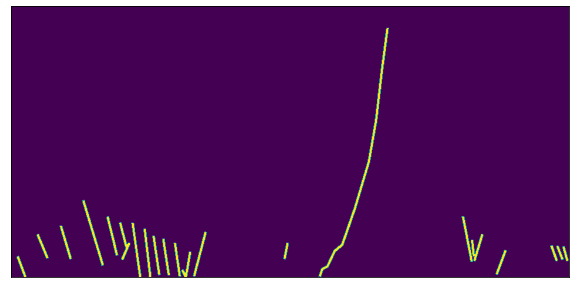

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

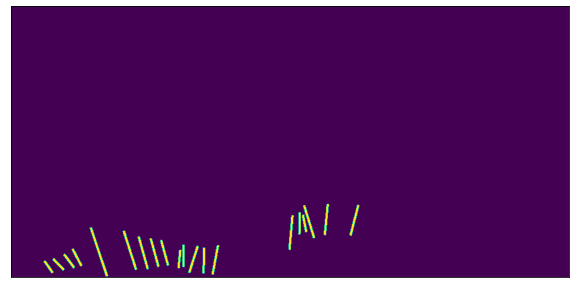

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

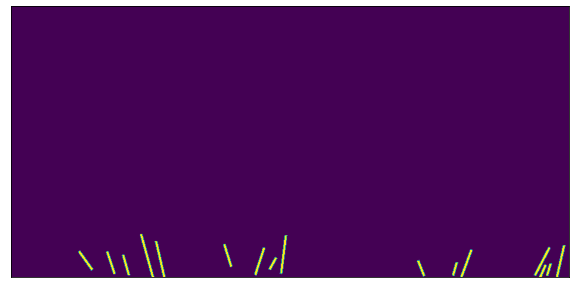

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

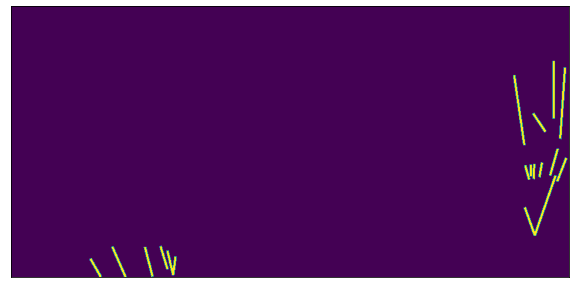

<IPython.core.display.Javascript object>

In [28]:
for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    data_tiles   = tile(data[100+100*i,:,:], size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    label = load_label(100+100*i)
    plt.imshow(label)
    plt.xticks([])
    plt.yticks([])